In [1]:
!git clone https://github.com/nhoyh/HR_IMU_falldetection_dataset.git
!cd HR_IMU_falldetection_dataset

Cloning into 'HR_IMU_falldetection_dataset'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 460 (delta 28), reused 45 (delta 28), pack-reused 415 (from 1)
Receiving objects: 100% (460/460), 12.30 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
!pip install scipy pandas numpy

In [3]:
import scipy.io

# Load a sample .mat file
mat = scipy.io.loadmat("/content/HR_IMU_falldetection_dataset/subject_01/fall/fall1.mat")

# Check the structure of the file
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'time', 'w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az', 'heart'])


In [4]:
# prompt: convert all .mat files in the dataset with structure HR_IMU_falldetection_dataset/subject_num/fall_or_nonfall/file.mat into csv files.
# save this new csv dataset.
# now take all the entries from the csv dataset, and combine them into one dataset. all data points have the same features.

import scipy.io
import pandas as pd
import os
import numpy as np

# Define the path to the dataset
dataset_path = "/content/HR_IMU_falldetection_dataset"

# Create a list to store all dataframes
all_dataframes = []

# Iterate through all subjects, fall/non-fall directories, and .mat files
for subject in os.listdir(dataset_path):
    # Skip hidden files or directories like .gitattributes and other files
    if subject.startswith('.') or not os.path.isdir(os.path.join(dataset_path, subject)):
        continue

    subject_dir = os.path.join(dataset_path, subject)
    if not os.path.isdir(subject_dir):
      continue

    for fall_type in ["fall", "non-fall"]:
        fall_dir = os.path.join(subject_dir, fall_type)
        for filename in os.listdir(fall_dir):
            if filename.endswith(".mat"):
                mat_file_path = os.path.join(fall_dir, filename)

                # Load the .mat file
                try:
                    mat = scipy.io.loadmat(mat_file_path)
                    # Get the minimum length among all arrays
                    min_len = min(len(mat[key].flatten()) for key in ["time", "w", "x", "y", "z", "droll", "dpitch", "dyaw", "ax", "ay", "az", "heart"] if key in mat)

                    # Extract data into a dictionary with consistent lengths
                    data_dict = {
                        # "time": mat["time"].flatten()[:min_len],
                        "w": mat["w"].flatten()[:min_len],
                        "x": mat["x"].flatten()[:min_len],
                        "y": mat["y"].flatten()[:min_len],
                        "z": mat["z"].flatten()[:min_len],
                        "droll": mat["droll"].flatten()[:min_len],
                        "dpitch": mat["dpitch"].flatten()[:min_len],
                        "dyaw": mat["dyaw"].flatten()[:min_len],
                        "ax": mat["ax"].flatten()[:min_len],
                        "ay": mat["ay"].flatten()[:min_len],
                        "az": mat["az"].flatten()[:min_len],
                        # "heart": mat["heart"].flatten()[:min_len]
                    }
                    data_dict['label'] = fall_type
                    # Convert to DataFrame
                    all_dataframes.append(pd.DataFrame(data_dict))
                    print(f"Processed {mat_file_path}")
                except Exception as e:
                    print(f"Error processing {mat_file_path}: {e}")

# Concatenate all dataframes into one
if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    # Save combined dataset as a CSV file
    combined_df.to_csv("/content/combined_dataset.csv", index=False)
    print("Combined dataset saved as combined_dataset.csv")
else:
    print("No .mat files found or processed.")

Processed /content/HR_IMU_falldetection_dataset/subject_21/fall/fall3.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/fall/fall1.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/fall/fall2.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/fall/fall4.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/fall/fall5.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/eat.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/clap.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/teeth.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/chair.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/stair.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/write.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/zip.mat
Processed /content/HR_IMU_falldetection_dataset/subject_21/non-fall/cloth.mat
Processed /

In [5]:
df = pd.read_csv("/content/combined_dataset.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381394 entries, 0 to 381393
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       381394 non-null  float64
 1   x       381394 non-null  float64
 2   y       381394 non-null  float64
 3   z       381394 non-null  float64
 4   droll   381394 non-null  float64
 5   dpitch  381394 non-null  float64
 6   dyaw    381394 non-null  float64
 7   ax      381394 non-null  float64
 8   ay      381394 non-null  float64
 9   az      381394 non-null  float64
 10  label   381394 non-null  object 
dtypes: float64(10), object(1)
memory usage: 32.0+ MB


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

scaler = StandardScaler()
# x = df.drop(['label'], axis=1)
df_fall = df[df['label'] == 'fall']
df_non = df[df['label'] == 'non-fall']
df_non = shuffle(df_non, random_state=42).reset_index(drop=True)
df_non = df_non.iloc[:len(df_fall)]
dataset = df.copy()
df = pd.concat([df_fall, df_non])
x = df.drop(['label'], axis=1)
y = df['label']


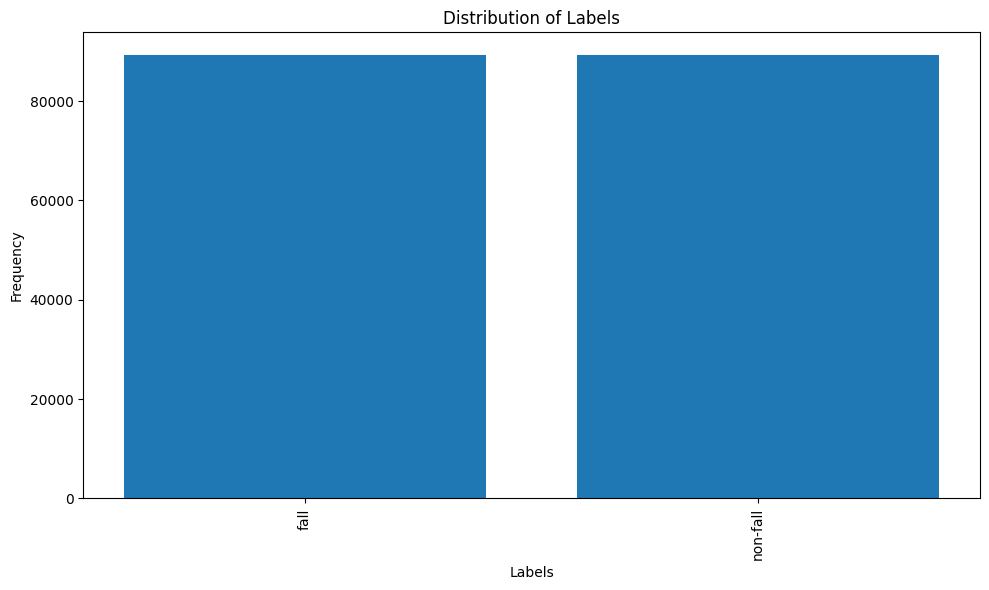

In [7]:
# prompt: use matplotlib to create a bar graph with distribution of labels

import matplotlib.pyplot as plt

# Assuming 'dataset' DataFrame is already loaded as in the previous code

# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [8]:
x.head(), x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178720 entries, 0 to 89359
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   w       178720 non-null  float64
 1   x       178720 non-null  float64
 2   y       178720 non-null  float64
 3   z       178720 non-null  float64
 4   droll   178720 non-null  float64
 5   dpitch  178720 non-null  float64
 6   dyaw    178720 non-null  float64
 7   ax      178720 non-null  float64
 8   ay      178720 non-null  float64
 9   az      178720 non-null  float64
dtypes: float64(10)
memory usage: 15.0 MB


(        w       x       y       z  droll  dpitch  dyaw     ax     ay     az
 0  0.1288  0.4937  0.0966  0.8545    0.0     0.0   0.0  0.002 -0.012  0.000
 1  0.1285  0.4937  0.0967  0.8545    1.4     0.3  -0.2  0.005 -0.006  0.000
 2  0.1282  0.4938  0.0969  0.8545    1.3     0.0  -0.3  0.009  0.003 -0.006
 3  0.1280  0.4938  0.0971  0.8545    0.5     0.0  -0.3  0.013  0.009 -0.008
 4  0.1281  0.4938  0.0974  0.8545    0.0     0.0   0.0  0.009  0.009 -0.011,
 None)

In [9]:
import scipy.io
import pandas as pd

# Load the .mat file
mat = scipy.io.loadmat('/content/HR_IMU_falldetection_dataset/subject_02/non-fall/chair.mat')

# Extract the desired features
features = ['w', 'x', 'y', 'z', 'droll', 'dpitch', 'dyaw', 'ax', 'ay', 'az']
data = {feature: mat[feature].flatten() for feature in features if feature in mat}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

           w       x       y       z  droll  dpitch  dyaw     ax     ay     az
0     0.7944 -0.1699 -0.5801 -0.0593 -218.7     1.8   7.1 -0.021  0.095 -0.297
1     0.7873 -0.1963 -0.5787 -0.0808 -180.3     9.6  15.7  0.058  0.065 -0.278
2     0.7797 -0.2158 -0.5792 -0.0994 -137.1    20.3  31.5  0.010  0.063 -0.245
3     0.7724 -0.2268 -0.5818 -0.1156  -84.2    21.9  53.3  0.008  0.010 -0.170
4     0.7661 -0.2281 -0.5867 -0.1289  -26.2    16.5  78.3 -0.012 -0.012 -0.094
...      ...     ...     ...     ...    ...     ...   ...    ...    ...    ...
1044  0.6066 -0.4639 -0.5135 -0.3912    1.8   -31.4 -35.0  0.148  0.111  0.000
1045  0.6113 -0.4639 -0.5080 -0.3910   -0.6   -31.5 -26.7  0.142  0.088 -0.011
1046  0.6154 -0.4632 -0.5031 -0.3917    1.1   -32.7 -16.5  0.134  0.068 -0.029
1047  0.6191 -0.4613 -0.4991 -0.3933    5.0   -34.0  -5.2  0.140  0.066 -0.034
1048  0.6223 -0.4580 -0.4963 -0.3956    8.4   -34.0   5.6  0.144  0.055 -0.052

[1049 rows x 10 columns]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 142976, Testing samples: 35744


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, max_samples=X_train.shape[0]//10, min_samples_split=100, verbose=1)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished


Model Accuracy: 0.92
              precision    recall  f1-score   support

        fall       0.95      0.88      0.91     17756
    non-fall       0.89      0.96      0.92     17988

    accuracy                           0.92     35744
   macro avg       0.92      0.92      0.92     35744
weighted avg       0.92      0.92      0.92     35744

Confusion Matrix:


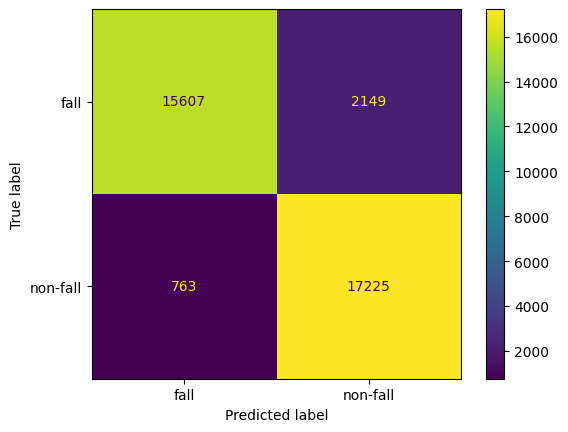

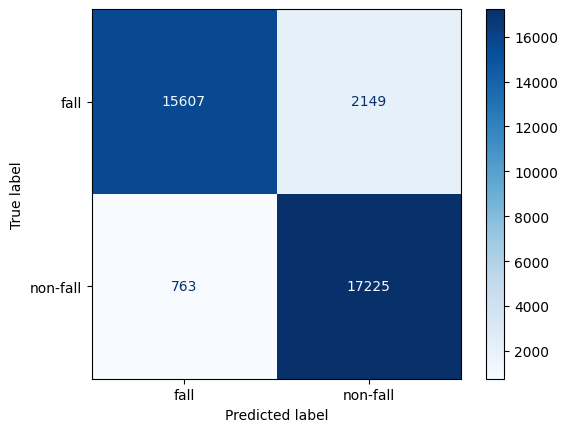

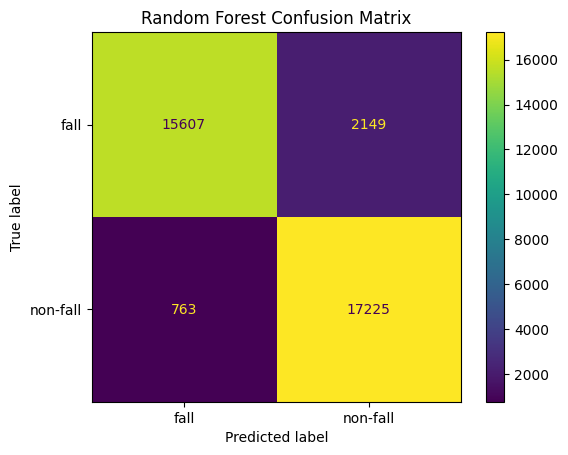

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Print Classification Report
print(classification_report(y_test, y_pred))

# Print Confusion Matrix
print("Confusion Matrix:")
conf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred).plot(cmap='Blues')
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:20:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.91
              precision    recall  f1-score   support

        fall       0.93      0.90      0.91     17756
    non-fall       0.90      0.93      0.92     17988

    accuracy                           0.91     35744
   macro avg       0.92      0.91      0.91     35744
weighted avg       0.92      0.91      0.91     35744

Confusion Matrix:


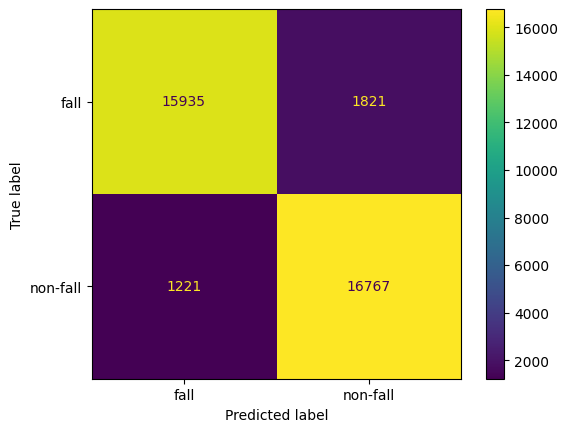

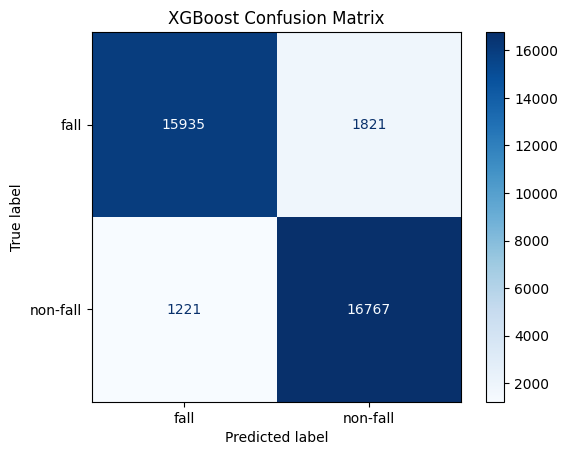

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder to your training labels and transform them
y_train_encoded = le.fit_transform(y_train)

# Initialize the XGBoost model
model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=10, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model_xgb.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)

# Transform predictions back to original labels if needed
y_pred_decoded = le.inverse_transform(y_pred_xgb)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_decoded)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")

print(classification_report(y_test, y_pred_decoded))

print("Confusion Matrix:")
conf_xgb = confusion_matrix(y_test, y_pred_decoded)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_decoded).plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
0:	learn: 0.6873310	total: 241ms	remaining: 23.8s
1:	learn: 0.6817340	total: 425ms	remaining: 20.8s
2:	learn: 0.6762863	total: 615ms	remaining: 19.9s
3:	learn: 0.6711395	total: 809ms	remaining: 19.4s
4:	learn: 0.6656289	total: 995ms	remaining: 18.9s
5:	learn: 0.6604472	total: 1.19s	remaining: 18.7s
6:	learn: 0.6553643	total: 1.4s	remaining: 18.6s
7:	learn: 0.6503762	total: 1.58s	remaining: 18.2s
8:	learn: 0.6452603	total: 1.77s	remaining: 17.9s
9:	learn: 0.6405288	total: 1.95s	remaining: 17.5s
10:	learn: 0.6357038	total: 2.15s	remaining: 17.4s
11:	learn: 0.6307859	total: 2.35s	remaining: 17.2s
12:	learn: 0.6261101	total: 2.53s	remaining: 16.9s
13:	learn: 0.6216129	total: 2.71s	remaining: 16.7s
14:	learn: 0.6171630	total: 2.9s	remaining: 16.4s
15:	learn: 0.6125968	total: 3.08s	remaining: 16.2s
16:	learn: 0.6081584	total: 3.42s	remaining: 16.7s
17:	learn: 0.6039395	total: 3.75s	remaining: 17.1s
18:	learn: 0.599

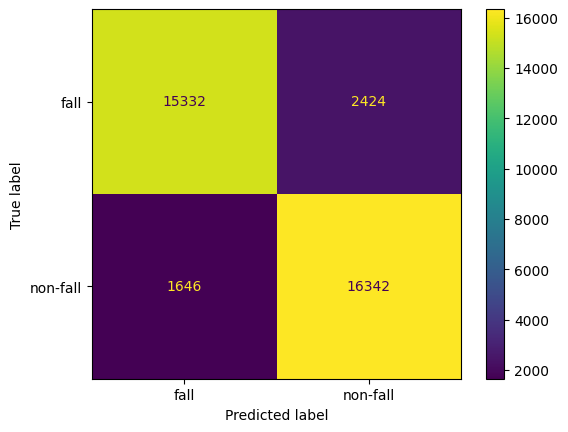

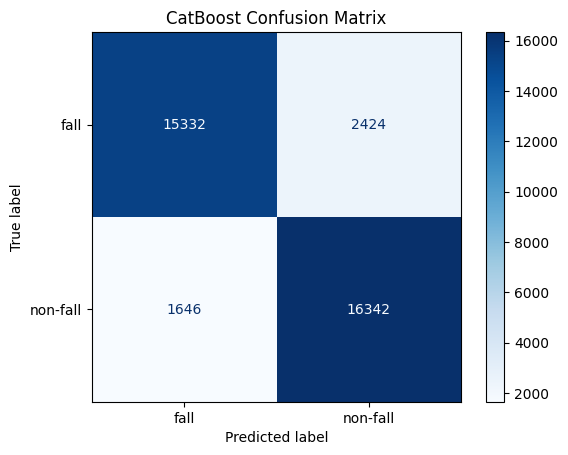

In [14]:
!pip install catboost
from catboost import CatBoostClassifier


model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.01, depth=10, loss_function='MultiClass')

# Train the model
model_catboost.fit(X_train, y_train, verbose=1)

# Make predictions
y_pred_catboost = model_catboost.predict(X_test)

# Evaluate the model
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost:.2f}")

print(classification_report(y_test, y_pred_catboost))

print("Confusion Matrix:")
conf_catboost = confusion_matrix(y_test, y_pred_catboost)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_catboost).plot(cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.show()

KNN Accuracy: 0.98
              precision    recall  f1-score   support

        fall       0.99      0.97      0.98     17872
    non-fall       0.97      0.99      0.98     17872

    accuracy                           0.98     35744
   macro avg       0.98      0.98      0.98     35744
weighted avg       0.98      0.98      0.98     35744

Confusion Matrix:


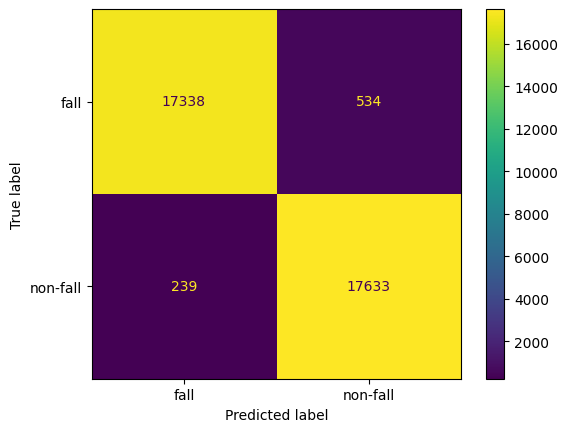

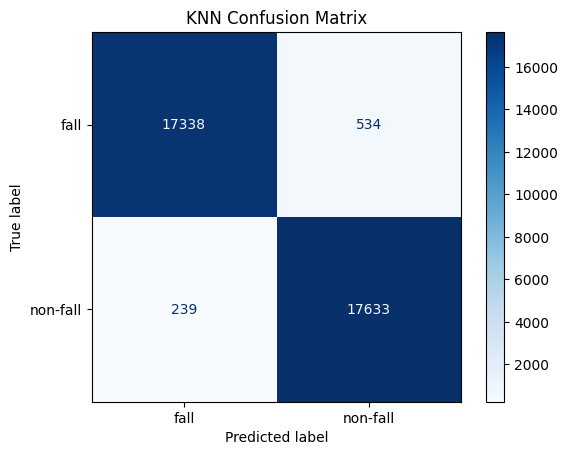

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = model_knn.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")

print(classification_report(y_test, y_pred_knn))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn).plot(cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()


In [17]:
import joblib

# Save Random Forest model
joblib.dump(model, 'random_forest_model.pkl')

# Save XGBoost model
joblib.dump(model_xgb, 'xgboost_model.pkl')

# Save CatBoost model
joblib.dump(model_catboost, 'catboost_model.pkl')

# Save KNN model
joblib.dump(model_knn, 'knn_model.pkl')

['knn_model.pkl']